##Dependency Installation and Import

In [3]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.4 MB/s eta 0:00:00


In [4]:
import random
import numpy as np
from google.colab import files
import zipfile
from zipfile import ZipFile
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from deap import base, creator, tools,algorithms

##Retrieval and Wrangling of Data

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucihere","key":"1c73be72364cc767c5cd7a18b19d4418"}'}

In [6]:
!mkdir ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c child-mind-institute-detect-sleep-states

100% 809M/811M [00:08<00:00, 60.9MB/s]
100% 811M/811M [00:08<00:00, 105MB/s] 


In [10]:
def zipextract(filepath,mode="r",remove=False,outpath = None):
  """
  Extracts contents of a .zip file into an output directory

  Input Parameters:
    filepath(str) = The filepath of the .zip file
    mode(str) = 'r' for read, 'w' for write
    remove(bool) = Whether the .zip file should remain or should be removed from current working directory
    outpath(str) = Output directory into which extracted files are sent to, after extraction

  Returns:
    None
  """

  with zipfile.ZipFile(filepath,mode) as datazip:
    datazip.extractall(path = outpath)
  if remove==True:
    cmd = "rm"

In [11]:
zipextract("/content/child-mind-institute-detect-sleep-states.zip",remove=True)

In [12]:
csv_data = pd.read_csv("/content/train_events.csv")
csv_data

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14506,fe90110788d2,35,onset,NaN,NaN


In [13]:
csv_data.isna().sum()

series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64

In [14]:
nonan_data = csv_data.dropna()

In [15]:
nonan_data

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
...,...,...,...,...,...
14501,fe90110788d2,32,wakeup,547152.0,2017-09-05T09:26:00-0400
14502,fe90110788d2,33,onset,556560.0,2017-09-05T22:30:00-0400
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400


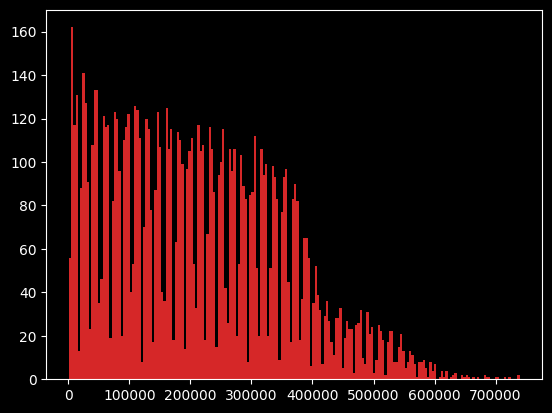

In [16]:
plt.style.use("dark_background")
plt.hist(nonan_data['step'],bins=200,color="tab:red")
plt.show()

In [17]:
x_data = pd.concat([nonan_data["night"],nonan_data["step"]],axis=1)
y_data = nonan_data["event"]

In [18]:
x_data

,night,step
0,1,4992.0
1,1,10932.0
2,2,20244.0
3,2,27492.0
4,3,39996.0
...,...,...
14501,32,547152.0
14502,33,556560.0
14503,33,560604.0
14504,34,574620.0


In [19]:
y_data

0         onset
1        wakeup
2         onset
3        wakeup
4         onset
          ...  
14501    wakeup
14502     onset
14503    wakeup
14504     onset
14505    wakeup
Name: event, Length: 9585, dtype: object

In [20]:
y_data.replace({"onset":0,"wakeup":1})

0        0
1        1
2        0
3        1
4        0
        ..
14501    1
14502    0
14503    1
14504    0
14505    1
Name: event, Length: 9585, dtype: int64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x_data,y_data.replace({"onset":0,"wakeup":1}),test_size=0.2,random_state=0)

In [22]:
X_train

,night,step
9787,17,288720.0
683,2,31176.0
13999,11,186516.0
2383,35,602280.0
12977,18,307536.0
...,...,...
11752,13,218496.0
13967,17,290100.0
6918,22,368256.0
4677,8,131904.0


In [23]:
y_train

9787     1
683      1
13999    1
2383     1
12977    1
        ..
11752    0
13967    1
6918     0
4677     1
3983     1
Name: event, Length: 7668, dtype: int64

##Models (without genetic algorithm parameter optimization)

###Logistic Regression

In [24]:
logmodel = LogisticRegression(max_iter=1000)

In [25]:
logmodel.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [26]:
logmodel.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
logmodel.score(X_test,y_test)

0.5033907146583203

In [28]:
print("Logistic Regressor\n",classification_report(y_true = np.array(y_test),y_pred = logmodel.predict(X_test),zero_division=1.0))

Logistic Regressor
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       952
           1       0.50      1.00      0.67       965

    accuracy                           0.50      1917
   macro avg       0.75      0.50      0.33      1917
weighted avg       0.75      0.50      0.34      1917



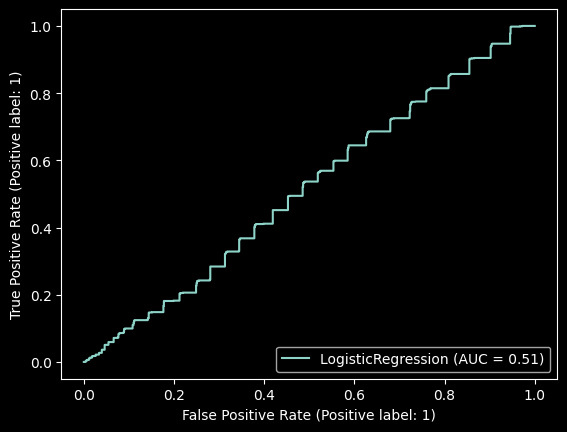

In [ ]:
log_disp = RocCurveDisplay.from_estimator(logmodel, X_test, y_test)

###Passive Aggressive Classifier

In [29]:
PACmodel = PassiveAggressiveClassifier(max_iter=1000,C=0.1,loss="squared_hinge")

In [30]:
PACmodel.fit(X_train,y_train)

PassiveAggressiveClassifier(C=0.1, loss='squared_hinge')

In [31]:
PACmodel.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
PACmodel.score(X_test,y_test)

0.4966092853416797

In [35]:
print("Passive Aggressive Classifier\n",classification_report(y_true = np.array(y_test),y_pred = PACmodel.predict(X_test),zero_division=1.0))

Passive Aggressive Classifier
               precision    recall  f1-score   support

           0       0.50      1.00      0.66       952
           1       1.00      0.00      0.00       965

    accuracy                           0.50      1917
   macro avg       0.75      0.50      0.33      1917
weighted avg       0.75      0.50      0.33      1917



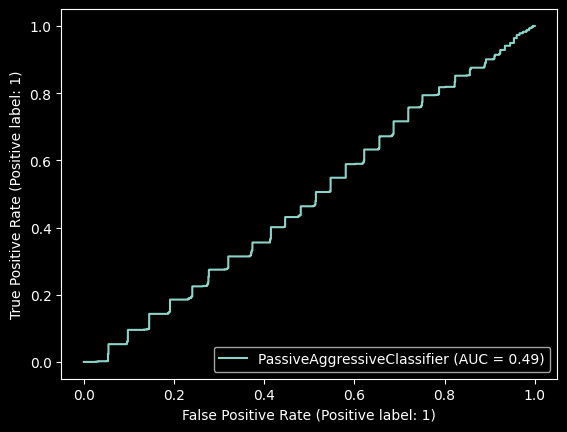

In [34]:
PAC_disp = RocCurveDisplay.from_estimator(PACmodel, X_test, y_test)

###Naive Bayes Classifier

In [36]:
GNBmodel = GaussianNB()

In [37]:
GNBmodel.fit(X_train,y_train)

GaussianNB()

In [38]:
GNBmodel.predict(X_test)

array([0, 0, 1, ..., 0, 0, 0])

In [39]:
GNBmodel.score(X_test,y_test)

0.4919144496609285

In [42]:
print("Naive Bayes Classifier\n",classification_report(y_true = np.array(y_test),y_pred = GNBmodel.predict(X_test),zero_division=1.0))

Naive Bayes Classifier
               precision    recall  f1-score   support

           0       0.49      0.66      0.56       952
           1       0.49      0.33      0.40       965

    accuracy                           0.49      1917
   macro avg       0.49      0.49      0.48      1917
weighted avg       0.49      0.49      0.48      1917



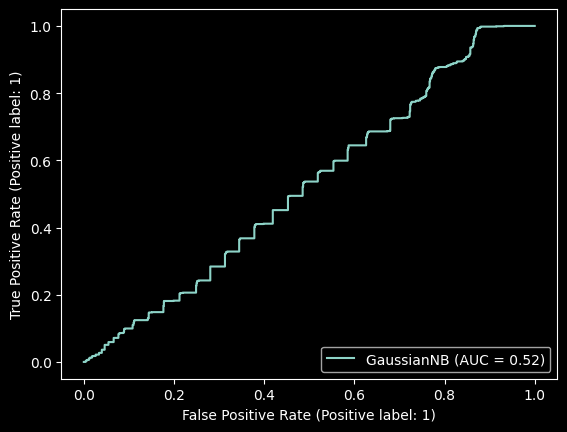

In [41]:
GNB_disp = RocCurveDisplay.from_estimator(GNBmodel, X_test, y_test)

###K-Nearest Neighbours

In [44]:
KNNmodel = KNeighborsClassifier()

In [45]:
KNNmodel.fit(X_train,y_train)

KNeighborsClassifier()

In [46]:
KNNmodel.predict(X_test)

array([1, 0, 1, ..., 1, 1, 1])

In [47]:
KNNmodel.score(X_test,y_test)

0.9238393322900366

In [48]:
print("K-Nearest Neighbor Classifier\n", classification_report(y_true = np.array(y_test),y_pred = KNNmodel.predict(X_test),zero_division=1.0))

K-Nearest Neighbor Classifier
               precision    recall  f1-score   support

           0       0.93      0.92      0.92       952
           1       0.92      0.93      0.92       965

    accuracy                           0.92      1917
   macro avg       0.92      0.92      0.92      1917
weighted avg       0.92      0.92      0.92      1917



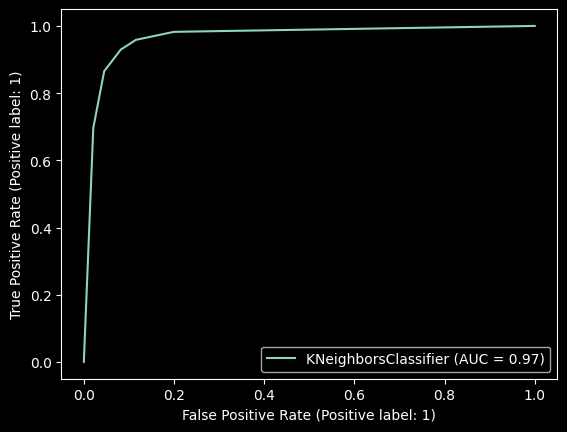

In [49]:
KNN_disp = RocCurveDisplay.from_estimator(KNNmodel, X_test, y_test)

###Multi-Layer Perceptron

In [50]:
MLPmodel = MLPClassifier(max_iter=1000,solver='adam')

In [51]:
MLPmodel.fit(X_train,y_train)

MLPClassifier(max_iter=1000)

In [52]:
MLPmodel.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [53]:
MLPmodel.score(X_test,y_test)

0.5033907146583203

In [56]:
print("Multi-Layer Perceptron\n", classification_report(y_true = np.array(y_test),y_pred = MLPmodel.predict(X_test),zero_division=1.0))

Multi-Layer Perceptron
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       952
           1       0.50      1.00      0.67       965

    accuracy                           0.50      1917
   macro avg       0.75      0.50      0.33      1917
weighted avg       0.75      0.50      0.34      1917



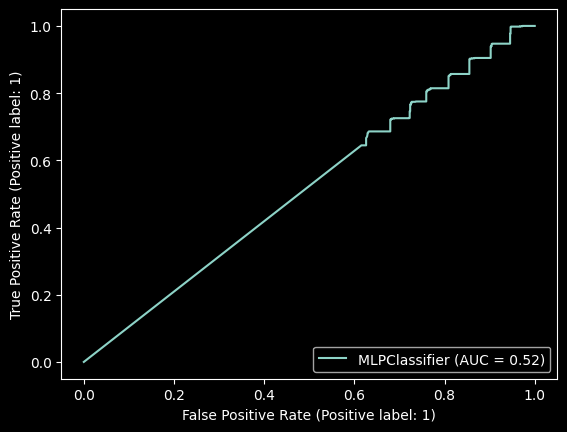

In [55]:
MLP_disp = RocCurveDisplay.from_estimator(MLPmodel, X_test, y_test)

###Support Vector Machine

In [57]:
SVCmodel = SVC(kernel="sigmoid")

In [58]:
SVCmodel.fit(X_train,y_train)

SVC(kernel='sigmoid')

In [59]:
SVCmodel.predict(X_test)

array([1, 1, 1, ..., 0, 0, 0])

In [60]:
SVCmodel.score(X_test,y_test)

0.4981742305685968

In [63]:
print("Support Vector Machine\n",classification_report(y_true = np.array(y_test),y_pred = SVCmodel.predict(X_test),zero_division=1.0))

Support Vector Machine
               precision    recall  f1-score   support

           0       0.49      0.49      0.49       952
           1       0.50      0.51      0.50       965

    accuracy                           0.50      1917
   macro avg       0.50      0.50      0.50      1917
weighted avg       0.50      0.50      0.50      1917



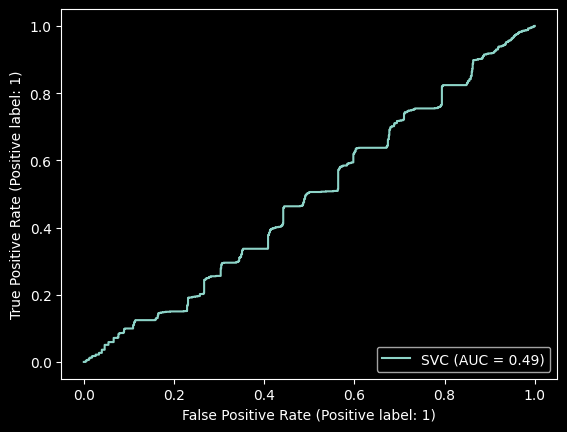

In [62]:
SVC_disp = RocCurveDisplay.from_estimator(SVCmodel, X_test, y_test)

###Decision Tree

In [64]:
DTCmodel = DecisionTreeClassifier(criterion="entropy",max_depth=40)

In [65]:
DTCmodel.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=40)

In [66]:
DTCmodel.predict(X_test)

array([1, 0, 1, ..., 1, 1, 1])

In [67]:
DTCmodel.score(X_test,y_test)

0.8236828377673449

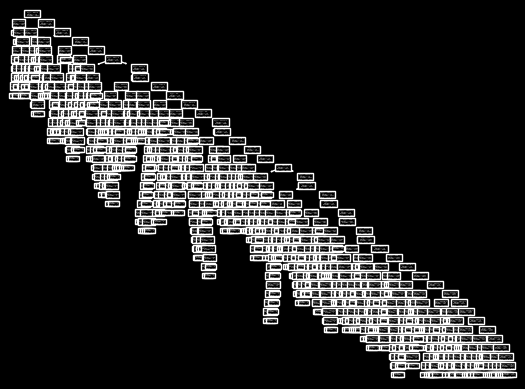

In [ ]:
plot_tree(DTCmodel)
plt.show()

In [68]:
print("Decision Tree\n",classification_report(y_true = np.array(y_test),y_pred = DTCmodel.predict(X_test),zero_division=1.0))

Decision Tree
               precision    recall  f1-score   support

           0       0.89      0.73      0.81       952
           1       0.78      0.91      0.84       965

    accuracy                           0.82      1917
   macro avg       0.83      0.82      0.82      1917
weighted avg       0.83      0.82      0.82      1917



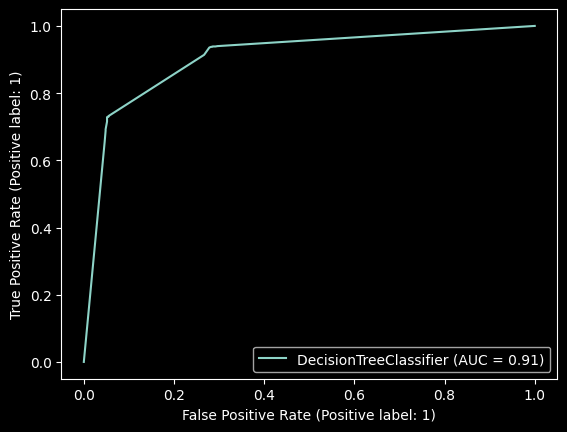

In [ ]:
DTC_disp = RocCurveDisplay.from_estimator(DTCmodel, X_test, y_test)

###Random Forest

In [69]:
RFmodel = RandomForestClassifier(n_estimators=5)

In [70]:
RFmodel.fit(X_train,y_train)

RandomForestClassifier(n_estimators=5)

In [71]:
RFmodel.predict(X_test)

array([1, 0, 1, ..., 1, 1, 1])

In [72]:
RFmodel.score(X_test,y_test)

0.909754825247783

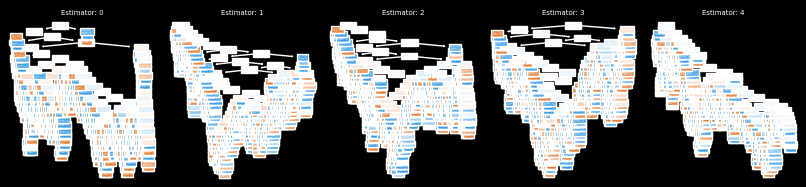

In [273]:
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2))
for index in range(0, 5):
    plot_tree(RFmodel.estimators_[index],
                   filled = True,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 5)

In [73]:
print("Random Forest\n",classification_report(y_true = np.array(y_test),y_pred = RFmodel.predict(X_test),zero_division=1.0))

Random Forest
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       952
           1       0.91      0.91      0.91       965

    accuracy                           0.91      1917
   macro avg       0.91      0.91      0.91      1917
weighted avg       0.91      0.91      0.91      1917



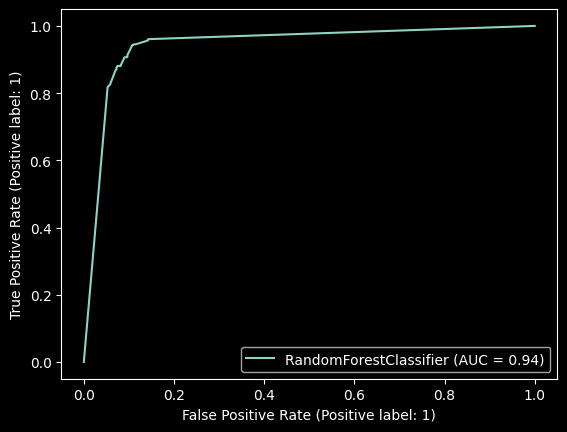

In [ ]:
RF_disp = RocCurveDisplay.from_estimator(RFmodel, X_test, y_test)